# Notebook to train the Hybrid ResNet-ViT & ViT

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id, clean_zone_identifier_files
from plotting_utils_torch import plot_loss_curves, make_confusion_matrix, view_image_data, plot_guidance_losses, plot_average_attention_scores, plot_correlation
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from models3D import ResnetFeatureExtractor, ResNetViT, pureViT, upsample_vit_attention
import json
import nibabel as nib
from scipy.stats import pearsonr, spearmanr # For Pearson and Spearman correlation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

#clean_zone_identifier_files("/home/diogommiranda/tese/")

/home/diogommiranda/tese/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-23 16:23:24.367799: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-23 16:23:25.369250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


# Select which Model to use
Note:
- When using ResNet and Hybrid Models the input shape is (91, 109, 91)
- When using PureViT the input shape is padded to (96, 112, 96) to make it divisible by a patch size of (16,16,16)

In [2]:
USE_MODEL = "purevit" # Choose model: "hybrid", "purevit"

if USE_MODEL == "hybrid":
    print("Using Hybrid model. \nExpected input shape is (91, 109, 91)")
    apply_padding = False
    EXPECTED_FINAL_VOLUME_SHAPE = (91, 109, 91)
    
elif USE_MODEL == "purevit":
    print("Using pure ViT model. \nExpected input shape is (96, 112, 96)")
    apply_padding = True
    EXPECTED_FINAL_VOLUME_SHAPE = (96, 112, 96)
else:
    raise ValueError("Invalid model choice. Use 'hybrid' or 'purevit'.")

Using pure ViT model. 
Expected input shape is (96, 112, 96)


In [3]:
NORMALIZATION = "mni_reg_CV" # Name of the directory with the datasets
DATASET = "smci_pmci_balanced" # Choose dataset: "smci_pmci_balanced", "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 4 # Set batch size

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max,
    apply_padding=apply_padding
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    apply_padding=apply_padding
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci_balanced/train...
    Found 349 files for class 'smci'
    Found 314 files for class 'pmci'
Calculated Min: -0.3496308922767639, Max: 2.7912356853485107
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci_balanced/test...
    Found 87 files for class 'smci'
    Found 78 files for class 'pmci'


torch.Size([1, 96, 112, 96])
Min: 0.11078770458698273, Max: 0.8640980124473572


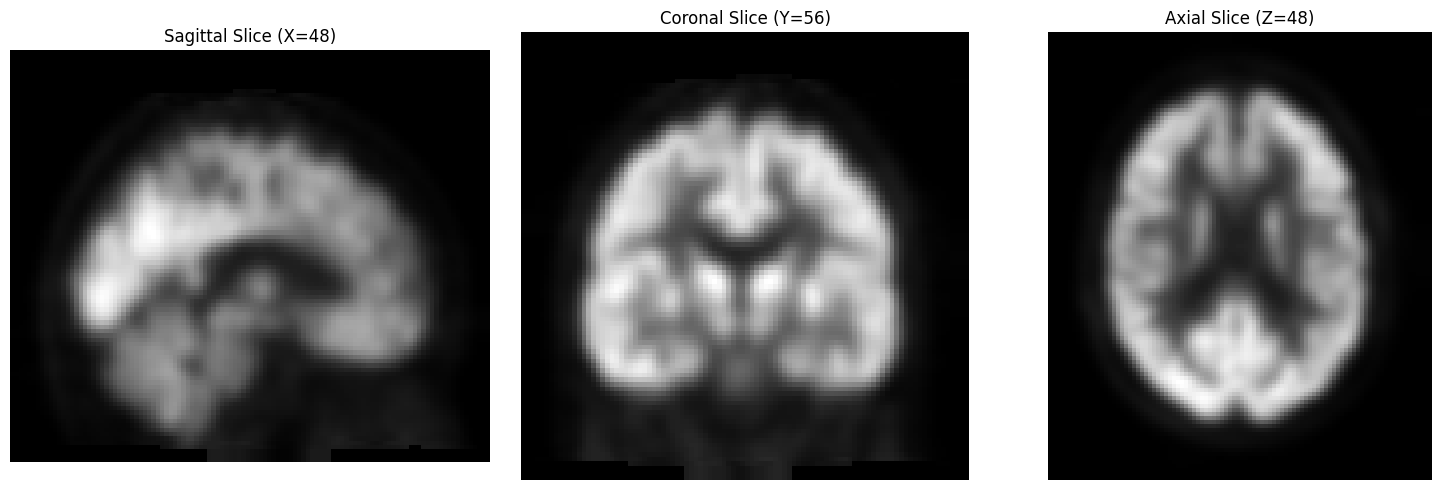

In [4]:
# Verify data with a test sample
i = 0
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    min_val = data[i].min().item()
    max_val = data[i].max().item()
    print(f"Min: {min_val}, Max: {max_val}")
    break

In [5]:
# Setting configurations for the best hybrid and pure ViT models

resnet_config = {
    'block': 'basic',
    'layers': [2, 2, 2, 2], # [2, 2, 2, 2] for ResNet18, [3, 4, 6, 3] for ResNet34
    'block_inplanes': [64, 128, 256, 512],
    'spatial_dims': 3,
    'n_input_channels': 1,
    'conv1_t_stride': 2,
    'num_classes': 1, 
    'shortcut_type': 'B',
    'bias_downsample': True
}

vit_config = {
    'in_channels': 256,
    'img_size': (6,7,6),
    'patch_size': (1,1,1),  
    'num_heads': 8,
    'hidden_size': 504,
    'mlp_dim': 2016,
    'num_layers': 7,
    'proj_type': 'perceptron',
    'pos_embed_type': 'sincos',
    'classification': True,
    'num_classes': 1,
    'dropout_rate': 0.0,
    'spatial_dims': 3,
    'post_activation': 'none',
    'qkv_bias': False,
    'save_attn': True,
    'save_attn_logits': True
}

purevit_config = {
    'in_channels': 1,
    'img_size': (96,112,96),
    'patch_size': (16,16,16),
    'num_heads': 12,
    'hidden_size': 768,
    'mlp_dim': 3072,
    'num_layers': 12,
    'proj_type': 'perceptron',
    'pos_embed_type': 'sincos',
    'classification': True,
    'num_classes': 1,
    'dropout_rate': 0.0,
    'spatial_dims': 3,
    'post_activation': 'none',
    'qkv_bias': False,
    'save_attn': True,
    'save_attn_logits': True
    }

# Get ROI mask and setup variables for the guidance loss

Mask volume shape: (1, 96, 112, 96)
Number of ROI voxels: 37384
Number of non-ROI voxels: 994808
Mask volume shape after adding batch dimension: torch.Size([1, 96, 112, 96])


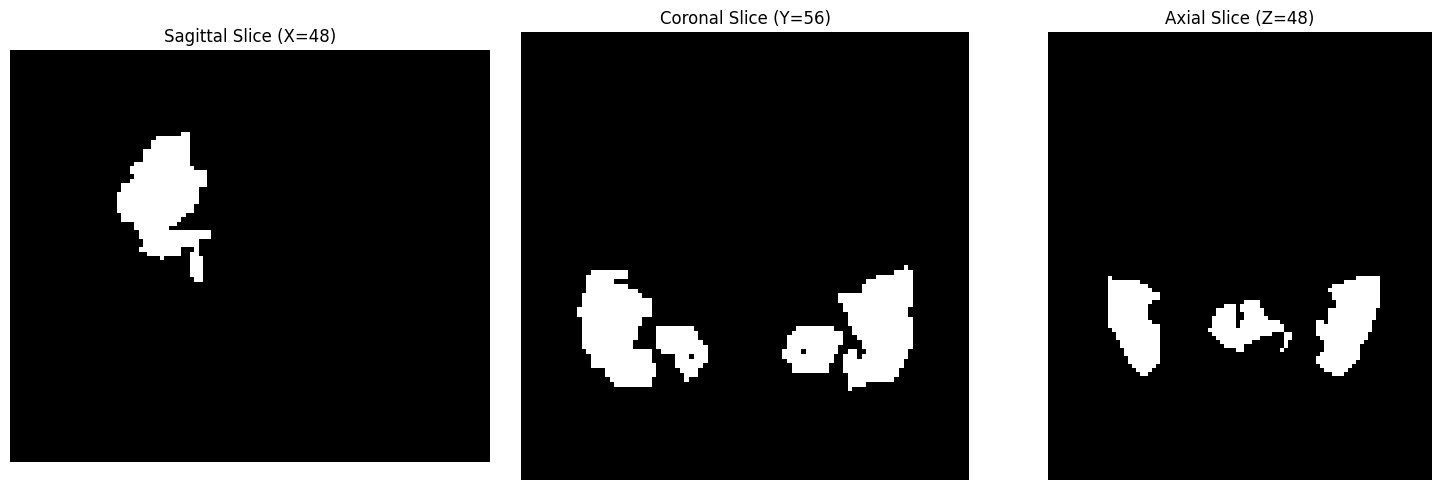

In [6]:
# Set up ROI mask to be used in the guidance loss function
mask_path = Path("/home/diogommiranda/tese/masks/ROI_MASK.nii")
mask_img = nib.load(mask_path)
mask_volume = mask_img.get_fdata(dtype=np.float32)
assert mask_volume.shape == (91, 109, 91), "Mask volume shape must be (91, 109, 91)"
if apply_padding:
    padding = (
        (2,3), # Pad width from 91 to 96
        (1,2), # Pad height from 109 to 112
        (2,3)  # Pad depth from 91 to 96
    )
    mask_volume = np.pad(mask_volume, padding, mode='edge')
    
mask_volume = np.expand_dims(mask_volume, axis=0)
mask_volume = np.transpose(mask_volume, (0, 3, 2, 1)) # Transpose to (depth, height, width)
print(f"Mask volume shape: {mask_volume.shape}")
mask_volume = torch.tensor(mask_volume, dtype=torch.float32)
view_image_data(mask_volume)

# Get number of ROI and non-ROI voxels in the mask - needed for the guidance loss function
roi_voxels = mask_volume[mask_volume == 1].numel()
print(f"Number of ROI voxels: {roi_voxels}")
non_roi_voxels = mask_volume[mask_volume == 0].numel()
print(f"Number of non-ROI voxels: {non_roi_voxels}")

mask_volume = mask_volume.to(device)
print(f"Mask volume shape after adding batch dimension: {mask_volume.shape}")


In [7]:
# Get token roi scores for correlation analysis
token_roi_mask = mask_volume.cpu().unsqueeze(0)
token_roi_mask = F.interpolate(
    input = token_roi_mask,
    mode = 'area',
    size = (6, 7, 6)
    )
token_roi_scores = token_roi_mask.numpy().flatten()
print(f"Token ROI scores shape: {token_roi_scores.shape}")

Token ROI scores shape: (252,)


# Select guidance loss config parameters

In [8]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----
RETURN_ATTENTION = 'raw' # Choose attention type: 'softmaxed', 'raw', 'none'
LEVEL = 'image' # Choose level-space to apply guidance loss: 'image', 'token'
#LOSS_FUNCTION = 'kvl' # choose loss function: 'kvl', 'weighted_sum'

if RETURN_ATTENTION == 'softmaxed':
    print("Using softmaxed attention maps in the guidance loss.")
elif RETURN_ATTENTION == 'raw':
    print("Using raw logits attention maps in the guidance loss.")
else:
    raise ValueError("Invalid attention type. Use 'softmaxed' or 'raw' to retrieve the attention maps.")

if LEVEL == 'image':
    print("Using image-level guidance loss.")
    mask_volume.to(device) # Move mask volume to device
if LEVEL == 'token':
    # Interpolate the mask volume to match the 
    # add batch dimension
    mask_volume = mask_volume.unsqueeze(0) # Add batch dimension
    mask_volume = F.interpolate(
    input = mask_volume,
    mode = 'area',
    size = (6, 7, 6)
    )
    token_roi_scores = mask_volume.flatten(start_dim=1)
    token_roi_scores = token_roi_scores.to(device) # Move token ROI scores to device
elif LEVEL != 'image':
    raise ValueError("Invalid level-space. Use 'image' or 'token'.")

Using raw logits attention maps in the guidance loss.
Using image-level guidance loss.


# Nested Cross-Validation

In [ ]:
# Base directory for layers and heads
if USE_MODEL == "hybrid":
    learning_rate = 2e-7
    weight_decay = 4e-3
    CLS_LAYER = 7
    NUM_EPOCHS = 80
    EARLY_STOP_PATIENCE = 80
    RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/roi_guidance/resnetvit/" + DATASET
elif USE_MODEL == "purevit":
    learning_rate = 5e-7
    weight_decay = 4e-3
    CLS_LAYER = 12
    NUM_EPOCHS = 604
    EARLY_STOP_PATIENCE = 604
    RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/roi_guidance/purevit/" + DATASET
else:
    raise ValueError("Invalid model type. Choose 'hybrid' or 'purevit'.")
os.makedirs(RESULTS_BASE_DIR, exist_ok=True)

# Set LOSS_TYPE = "SOFTMAXED_ENERGY" to run Energy loss SPAN-like loss function with upsampled softmaxed attention maps
    # Must set USE_AVG = False
# Set LOSS_TYPE = "RAW_ENERGY" to run Energy loss function with upsampled raw attention maps
    # Set USE_AVG = True to use average-roi and non-roi voxel scores
    # Set USE_AVG = False to use the summation of all roi and non-roi voxel scores
    
LOSS_TYPE = "RAW_ENERGY" # Choose loss type: "RAW_ENERGY" or "SOFTMAXED_ENERGY"
RUN_CV = False # Set to True to run full K-Fold Cross-Validation, False to run only one fold for testing purposes
USE_FOLD = 4 # Fold to use when RUN_CV is False.
USE_AVG_RAW = True
USE_EARLY_STOPPING = False # Set to True to use early stopping

lambda_factors = [0.0015] # Guidance loss lambda factors
alpha_factors = [1.0] 


if LOSS_TYPE == "SOFTMAXED_ENERGY":
    RETURN_ATTENTION = 'softmaxed'
    USE_AVG = False
    # softmax token roi scores
    token_roi_scores = F.softmax(torch.tensor(token_roi_scores, dtype=torch.float32), dim=0).numpy()
    assert USE_AVG == False, "For SPAN-like loss function, USE_AVG must be False."
elif LOSS_TYPE == "RAW_ENERGY":
    RETURN_ATTENTION = 'raw'
    USE_AVG = USE_AVG_RAW # Set to True to use average-roi and non-roi voxel scores. False to use the summation of all roi and non-roi voxel scores.
else:
    raise ValueError("Invalid loss type. Use 'RAW_ENERGY' or 'SOFTMAXED_ENERGY'.")

N_SPLITS = 5

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

overall_start_time = time.time()

for alpha_factor in alpha_factors:
    for lambda_factor in lambda_factors:
        print("=" * 60)
        print(f"Testing Combination: alpha={alpha_factor} lambda={lambda_factor} for CLS_LAYER={CLS_LAYER} and {USE_MODEL} model")

        if LOSS_TYPE == "RAW_ENERGY":
            combo_dir_name = f"Raw Energy Loss (USE_AVG={USE_AVG})/Layer{CLS_LAYER}/alpha={alpha_factor}/lambda_{lambda_factor}"
        elif LOSS_TYPE == "SOFTMAXED_ENERGY":
            combo_dir_name = f"Softmaxed Energy Loss (SPAN-like)/Layer{CLS_LAYER}/alpha={alpha_factor}/lambda_{lambda_factor}"
        if RUN_CV:
            combo_dir_name += f" (CV)"
        else:
            combo_dir_name += f" (Fold {USE_FOLD}) - {NUM_EPOCHS} vf"
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        if os.path.exists(combo_results_dir):
            print(f"\nDirectory {combo_results_dir} already exists. Skipping...\n")
            continue
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"    Saving results for this combo to: {combo_results_dir}")
        print("=" * 60)

        start_time_combination = time.time()
        
        current_combo_val_losses = []
        
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []
        
        current_combo_val_sensitivities = []
        current_combo_val_specificities = []
        current_combo_val_baccs = []
        current_combo_val_f1s = []
        current_combo_val_mccs = []
        
        current_combo_val_pearson_corrs = []
        current_combo_val_spearmanr_corrs = []

        current_combo_test_losses = []

        current_combo_test_accuracies = []
        current_combo_test_aucs = []
        
        current_combo_test_sensitivities = []
        current_combo_test_specificities = []
        current_combo_test_baccs = []
        current_combo_test_f1s = []
        current_combo_test_mccs = []
        
        current_combo_test_pearson_corrs = []
        current_combo_test_spearmanr_corrs = []

        fold_no = 1

        # ----- K-Fold Cross-Validation -----
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            
            # Runs only desired fold and skips the rest: for testing purposes
            if not RUN_CV and fold_no != USE_FOLD:
                print(f"Skipping Fold {fold_no} (not in CV mode and not the desired fold {USE_FOLD})")
                fold_no += 1
                continue
            
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                    raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                apply_padding=apply_padding
            ) 
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                apply_padding=apply_padding
            )
            
            # Create test dataset
            test_data = create_dataloader(
                paths=test_paths,
                labels=test_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False,
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                apply_padding=apply_padding
                )

            if fold_train_data is None or fold_val_data is None or test_data is None:
                    raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
                
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            # Create the model
            if USE_MODEL == "hybrid":
                resnet_feature_extractor = ResnetFeatureExtractor(resnet_config=resnet_config)
                model = ResNetViT(resnet_feature_extractor, vit_config).to(device)
            elif USE_MODEL == "purevit":
                model = pureViT(purevit_config).to(device)
            else:
                raise ValueError("Invalid model type. Choose 'hybrid' or 'purevit'.")

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
            best_val_loss = float('inf')
            best_val_acc = -float('inf')
            best_val_bacc = -float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [],
                    'train_classification_loss': [], 'train_guidance_loss': [], 'train_penalization_term_loss': [], 'train_reward_term_loss':[], 'train_avg_att_roi': [], 'train_avg_att_non_roi': [],
                    'val_loss': [], 'val_accuracy': [], 'val_auc': [],
                    'val_classification_loss': [], 'val_guidance_loss': [], 'val_penalization_term_loss': [], 'val_reward_term_loss': [], 'val_avg_att_roi': [], 'val_avg_att_non_roi': [],
                    'val_sensitivity': [], 'val_specificity': [], 'val_bacc': [], 'val_f1': [], 'val_mcc': [],
                    'train_pearson_corr': [], 'train_spearmanr_corr': [], 'val_pearson_corr': [], 'val_spearmanr_corr': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # --- Train phase ---
                model.train()
                
                running_loss = 0.0
                
                running_classification_loss = 0.0
                running_guidance_loss = 0.0
                running_penalization_term_loss = 0.0
                running_reward_term_loss = 0.0
                
                running_avg_att_roi = 0.0
                running_avg_att_non_roi = 0.0
                
                train_cls_attn = []
                
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs, attention_maps = model(inputs, return_attention=RETURN_ATTENTION)
                        classification_loss = criterion(outputs, labels)
                    
                        if USE_MODEL == "hybrid":
                            attn_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True)
                        elif USE_MODEL == "purevit":
                            attn_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True) # determine the exact layer later   
                        cls_attn = attn_map[:, 0, 1:] # Get CLS attention vector
                        
                        train_cls_attn.append(cls_attn.detach().cpu())
                        
                        train_att_volume = upsample_vit_attention(cls_attn, EXPECTED_FINAL_VOLUME_SHAPE, (6, 7, 6)) # Get voxel-wise CLS attention map
                        
                        if USE_AVG == False:
                            penalization_term_loss = torch.mean(torch.sum(torch.multiply(train_att_volume, 1-mask_volume), dim=(1,2,3))) # penalization term of the guidance loss across the batch
                            reward_term_loss = - alpha_factor * (non_roi_voxels/roi_voxels) * torch.mean((torch.sum(torch.multiply(train_att_volume, mask_volume), dim=(1,2,3)))) # reward term of the guidance loss across the batch
                        else:
                            penalization_term_loss = torch.mean(torch.sum(torch.multiply(train_att_volume, 1-mask_volume), dim=(1,2,3))/ non_roi_voxels)
                            reward_term_loss = - alpha_factor * torch.mean((torch.sum(torch.multiply(train_att_volume, mask_volume), dim=(1,2,3)) / roi_voxels))
                    
                        guidance_loss = lambda_factor * (penalization_term_loss + reward_term_loss)
                    
                        loss = classification_loss + guidance_loss
                
                        avg_att_roi = torch.mean(torch.sum(torch.multiply(train_att_volume, mask_volume), dim=(1,2,3)) / roi_voxels)
                        avg_att_non_roi = torch.mean(torch.sum(torch.multiply(train_att_volume, (1 - mask_volume)), dim=(1,2,3)) / non_roi_voxels)
                            

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    running_classification_loss += classification_loss.item() * inputs.size(0)
                    running_guidance_loss += guidance_loss.item() * inputs.size(0)
                    running_penalization_term_loss += penalization_term_loss.item() * inputs.size(0)
                    running_reward_term_loss += reward_term_loss.item() * inputs.size(0)
                    
                    running_avg_att_roi += avg_att_roi.item() * inputs.size(0)
                    running_avg_att_non_roi += avg_att_non_roi.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())

                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                
                train_classification_loss = running_classification_loss / len(fold_train_data.dataset)
                train_guidance_loss = running_guidance_loss / len(fold_train_data.dataset)
                train_penalization_term_loss = running_penalization_term_loss / len(fold_train_data.dataset)
                train_reward_term_loss = running_reward_term_loss / len(fold_train_data.dataset)
                
                train_avg_att_roi = running_avg_att_roi / len(fold_train_data.dataset)
                train_avg_att_non_roi = running_avg_att_non_roi / len(fold_train_data.dataset)
                
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                
                history['train_loss'].append(train_loss)
                
                history['train_classification_loss'].append(train_classification_loss)
                history['train_guidance_loss'].append(train_guidance_loss)
                history['train_penalization_term_loss'].append(train_penalization_term_loss)
                history['train_reward_term_loss'].append(train_reward_term_loss)
                
                history['train_avg_att_roi'].append(train_avg_att_roi)
                history['train_avg_att_non_roi'].append(train_avg_att_non_roi)
                
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)
                
                train_cls_attn = torch.cat(train_cls_attn, dim=0) # Concatenate CLS attention vectors from all batches
                train_cls_attn_scores = torch.mean(train_cls_attn, dim=0).numpy() # Average across batches
                
                train_pearson_corr = pearsonr(train_cls_attn_scores, token_roi_scores)[0]
                history['train_pearson_corr'].append(train_pearson_corr)
                train_spearmanr_corr = spearmanr(train_cls_attn_scores, token_roi_scores)[0]
                history['train_spearmanr_corr'].append(train_spearmanr_corr)

                # --- Validation phase ---
                model.eval()
                
                running_loss = 0.0
                
                running_classification_loss = 0.0
                running_guidance_loss = 0.0
                running_penalization_term_loss = 0.0
                running_reward_term_loss = 0.0
                
                running_avg_att_roi = 0.0
                running_avg_att_non_roi = 0.0
                
                val_cls_attn = []
                
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs, attention_maps = model(inputs, return_attention=RETURN_ATTENTION)
                            classification_loss = criterion(outputs, labels)
                            
                            if USE_MODEL == "hybrid":
                                attn_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True)
                            elif USE_MODEL == "purevit":
                                attn_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True) # determine the exact layer later   
                            cls_attn = attn_map[:, 0, 1:] # CLS attention vector
                            
                            val_cls_attn.append(cls_attn.detach().cpu())
                                                    
                            att_volume = upsample_vit_attention(cls_attn, EXPECTED_FINAL_VOLUME_SHAPE, (6, 7, 6)) # Get voxel-wise CLS attention map

                            if USE_AVG == False:
                                penalization_term_loss = torch.mean(torch.sum(torch.multiply(att_volume, 1-mask_volume), dim=(1,2,3))) # penalization term of the guidance loss across the batch
                                reward_term_loss = - alpha_factor * (non_roi_voxels/roi_voxels) * torch.mean((torch.sum(torch.multiply(att_volume, mask_volume), dim=(1,2,3)))) # reward term of the guidance loss across the batch
                            else:
                                penalization_term_loss = torch.mean(torch.sum(torch.multiply(att_volume, 1-mask_volume), dim=(1,2,3))/ non_roi_voxels)
                                reward_term_loss = - alpha_factor * torch.mean((torch.sum(torch.multiply(att_volume, mask_volume), dim=(1,2,3)) / roi_voxels))
                        
                            guidance_loss = lambda_factor * (penalization_term_loss + reward_term_loss)
                        
                            loss = classification_loss + guidance_loss
                            
                            avg_att_roi = torch.mean(torch.sum(torch.multiply(att_volume, mask_volume), dim=(1,2,3)) / roi_voxels)
                            avg_att_non_roi = torch.mean(torch.sum(torch.multiply(att_volume, (1 - mask_volume)), dim=(1,2,3)) / non_roi_voxels)
                        
                        running_loss += loss.item() * inputs.size(0)
                        
                        running_classification_loss += classification_loss.item() * inputs.size(0)
                        running_guidance_loss += guidance_loss.item() * inputs.size(0)
                        running_penalization_term_loss += penalization_term_loss.item() * inputs.size(0)
                        running_reward_term_loss += reward_term_loss.item() * inputs.size(0)
                        
                        running_avg_att_roi += avg_att_roi.item() * inputs.size(0)
                        running_avg_att_non_roi += avg_att_non_roi.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = running_loss / len(fold_val_data.dataset)
                
                val_classification_loss = running_classification_loss / len(fold_val_data.dataset)
                val_guidance_loss = running_guidance_loss / len(fold_val_data.dataset)
                val_penalization_term_loss = running_penalization_term_loss / len(fold_val_data.dataset)
                val_reward_term_loss = running_reward_term_loss / len(fold_val_data.dataset)
                
                val_avg_att_roi = running_avg_att_roi / len(fold_val_data.dataset)
                val_avg_att_non_roi = running_avg_att_non_roi / len(fold_val_data.dataset)
                
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                
                val_true = val_targets.astype(int)
                val_pred = (val_pred_probs >= 0.5).astype(int)
                
                val_sensitivity = recall_score(val_true, val_pred, pos_label=1)
                val_specificity = recall_score(val_true, val_pred, pos_label=0)
                val_bacc = balanced_accuracy_score(val_true, val_pred)
                val_f1 = f1_score(val_true, val_pred, average='weighted')
                val_mcc = matthews_corrcoef(val_true, val_pred)
                
                history['val_loss'].append(val_loss)
                
                history['val_classification_loss'].append(val_classification_loss)
                history['val_guidance_loss'].append(val_guidance_loss)
                history['val_penalization_term_loss'].append(val_penalization_term_loss)
                history['val_reward_term_loss'].append(val_reward_term_loss)
                
                history['val_avg_att_roi'].append(val_avg_att_roi)
                history['val_avg_att_non_roi'].append(val_avg_att_non_roi)
                
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)
                
                history['val_sensitivity'].append(val_sensitivity)
                history['val_specificity'].append(val_specificity)
                history['val_bacc'].append(val_bacc)
                history['val_f1'].append(val_f1)
                history['val_mcc'].append(val_mcc)
                
                val_cls_attn = torch.cat(val_cls_attn, dim=0) # Concatenate CLS attention vectors from all batches
                val_cls_attn_scores = torch.mean(val_cls_attn, dim=0).numpy() # Average across batches
                
                val_pearson_corr = pearsonr(val_cls_attn_scores, token_roi_scores)[0]
                history['val_pearson_corr'].append(val_pearson_corr)
                val_spearmanr_corr = spearmanr(val_cls_attn_scores, token_roi_scores)[0]
                history['val_spearmanr_corr'].append(val_spearmanr_corr)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                #print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                        #f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} "
                        #f"Train classification Loss: {train_classification_loss:.5f}, Train Guidance Loss: {train_guidance_loss:.5f}, Train Penalization Term Loss: {train_penalization_term_loss:.5f}, Train Reward Term Loss: {train_reward_term_loss:.5f} | "
                        #f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f} "
                        #f"Val classification Loss: {val_classification_loss:.5f}, Val Guidance Loss: {val_guidance_loss:.5f}, Val Penalization Term Loss: {val_penalization_term_loss:.5f}, Val Reward Term Loss: {val_reward_term_loss:.5f} | ")
                

                # Early stopping check
                if USE_EARLY_STOPPING:
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        epochs_no_improve = 0
                        # Save the model state with the lowest validation loss
                        best_model_state = model.state_dict()
                        best_epoch = epoch + 1
                    else:
                        epochs_no_improve += 1
                    
                    if epochs_no_improve >= EARLY_STOP_PATIENCE:
                        model.load_state_dict(best_model_state)
                        print(f"\nEarly stopping triggered. Restoring best model weights from epoch {best_epoch}.\n")
                        break
                    
                if train_loss < -2.0:
                    print(f" We stop training here to avoid auxiliary loss dominating the classification loss.")
                    break
            
            if not USE_EARLY_STOPPING:
                best_epoch = NUM_EPOCHS
                print(f"Training completed for {NUM_EPOCHS} epochs without early stopping.")
                best_model_state = model.state_dict()
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE and USE_EARLY_STOPPING:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)
            
            plot_guidance_losses(history, fold_dir)
            plot_average_attention_scores(history, fold_dir)
            plot_correlation(history, fold_dir, 'pearson')
            plot_correlation(history, fold_dir, 'spearmanr')
            
            
            # Evaluate the fold
            best_epoch_index = best_epoch - 1
            
            val_loss_best = history['val_loss'][best_epoch_index]
            
            val_classification_loss_best = history['val_classification_loss'][best_epoch_index]
            val_guidance_loss_best = history['val_guidance_loss'][best_epoch_index]
            val_penalization_term_loss_best = history['val_penalization_term_loss'][best_epoch_index]
            val_reward_term_loss_best = history['val_reward_term_loss'][best_epoch_index]
            
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            
            val_sensitivity_best = history['val_sensitivity'][best_epoch_index]
            val_specificity_best = history['val_specificity'][best_epoch_index]
            val_bacc_best = history['val_bacc'][best_epoch_index]
            val_f1_best = history['val_f1'][best_epoch_index]
            val_mcc_best = history['val_mcc'][best_epoch_index]
            
            val_pearson_corr_best = history['val_pearson_corr'][best_epoch_index]
            val_spearmanr_corr_best = history['val_spearmanr_corr'][best_epoch_index]
            
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}, \n"
                f"    Classification Loss: {val_classification_loss_best:.4f}, Guidance Loss: {val_guidance_loss_best:.4f}, Penalization Term Loss: {val_penalization_term_loss_best:.4f}, Reward Term Loss: {val_reward_term_loss_best:.4f}\n"
                f"    Sensitivity: {val_sensitivity_best:.4f}, Specificity: {val_specificity_best:.4f}, BACC: {val_bacc_best:.4f}, F1: {val_f1_best:.4f}, MCC: {val_mcc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
        
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            current_combo_val_sensitivities.append(val_sensitivity_best)
            current_combo_val_specificities.append(val_specificity_best)
            current_combo_val_baccs.append(val_bacc_best)
            current_combo_val_f1s.append(val_f1_best)
            current_combo_val_mccs.append(val_mcc_best)
            
            current_combo_val_pearson_corrs.append(val_pearson_corr_best)
            current_combo_val_spearmanr_corrs.append(val_spearmanr_corr_best)
            
            optimizer_name = optimizer.__class__.__name__
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1
            
            # Save the validation metrics for current fold
            val_metrics_file_path = os.path.join(fold_dir, "val_results.txt")
            with open(val_metrics_file_path, "w") as f:
                f.write("--- Validation Metrics ---\n")
                f.write(f"Loss:        {val_loss_best:.4f}\n")
                f.write(f"Accuracy:    {val_accuracy_best:.4f}\n")
                f.write(f"Sensitivity: {val_sensitivity_best:.4f}\n")
                f.write(f"Specificity: {val_specificity_best:.4f}\n")
                f.write(f"Balanced Accuracy (BACC): {val_bacc_best:.4f}\n")
                f.write(f"F1 Score (Weighted):      {val_f1_best:.4f}\n")
                f.write(f"Matthews Corr Coef (MCC): {val_mcc_best:.4f}\n")
                f.write(f"Area Under the Curve (AUC): {val_auc_best:.4f}\n")
                f.write(f"Best Epoch: {best_epoch}\n")
                f.write(f"Classification Loss: {val_classification_loss_best:.4f}\n")
                f.write(f"Guidance Loss: {val_guidance_loss_best:.4f}\n")
                f.write(f"Penalization Term Loss: {val_penalization_term_loss_best:.4f}\n")
                f.write(f"Reward Term Loss: {val_reward_term_loss_best:.4f}\n")
                f.write(f"Pearson Correlation: {val_pearson_corr_best:.6f}\n")
                f.write(f"Spearman Correlation: {val_spearmanr_corr_best:.6f}\n")
            
            # --- Evaluate the model on the test data ---
            
            # Note: He evaluate the model on the test data after training on each fold to avoid re-training the model with the best hyperparameters and save time.
            # Note: This is not an issue for the ResNet model, but it is for the ViT models.
            # Note: The Hyperparameters are empirically selected based on the Validation set.
            
            model.eval()
            running_loss = 0.0
            
            running_classification_loss = 0.0
            running_guidance_loss = 0.0
            running_penalization_term_loss = 0.0
            running_reward_term_loss = 0.0
            
            running_avg_att_roi = 0.0
            running_avg_att_non_roi = 0.0
            
            test_cls_attn = []
            
            test_pred_probs = []
            test_targets = []

            with torch.inference_mode():
                for inputs, labels in test_data:
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)

                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs, attention_maps = model(inputs, return_attention=RETURN_ATTENTION)
                        classification_loss = criterion(outputs, labels)
                        
                        if USE_MODEL == "hybrid":
                            attn_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True)
                        elif USE_MODEL == "purevit":
                            attn_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True) # determine the exact layer later   
                        cls_attn = attn_map[:, 0, 1:] # CLS attention vector
                        
                        test_cls_attn.append(cls_attn.detach().cpu())
                        
                        att_volume = upsample_vit_attention(cls_attn, EXPECTED_FINAL_VOLUME_SHAPE, (6, 7, 6)) # Get voxel-wise CLS attention map
                        
                        if USE_AVG == False:
                            penalization_term_loss = torch.mean(torch.sum(torch.multiply(att_volume, 1-mask_volume), dim=(1,2,3))) # penalization term of the guidance loss across the batch
                            reward_term_loss = - alpha_factor * (non_roi_voxels/roi_voxels) * torch.mean((torch.sum(torch.multiply(att_volume, mask_volume), dim=(1,2,3)))) # reward term of the guidance loss across the batch
                        else:
                            penalization_term_loss = torch.mean(torch.sum(torch.multiply(att_volume, 1-mask_volume), dim=(1,2,3))/ non_roi_voxels)
                            reward_term_loss = - alpha_factor * torch.mean((torch.sum(torch.multiply(att_volume, mask_volume), dim=(1,2,3)) / roi_voxels))
                    
                        guidance_loss = lambda_factor * (penalization_term_loss + reward_term_loss)
                    
                        loss = classification_loss + guidance_loss
                    
                    running_loss += loss.item() * inputs.size(0)
                    
                    running_classification_loss += classification_loss.item() * inputs.size(0)
                    running_guidance_loss += guidance_loss.item() * inputs.size(0)
                    running_penalization_term_loss += penalization_term_loss.item() * inputs.size(0)
                    running_reward_term_loss += reward_term_loss.item() * inputs.size(0)
                
                    prob_outputs = torch.sigmoid(outputs)
                    
                    test_pred_probs.extend(prob_outputs.cpu().numpy())
                    test_targets.extend(labels.cpu().numpy())

            test_targets = np.array(test_targets).flatten()
            test_pred_probs = np.array(test_pred_probs).flatten()

            # Calculate test loss and accuracy
            test_loss = running_loss / len(test_data.dataset)
            
            test_classification_loss = running_classification_loss / len(test_data.dataset)
            test_guidance_loss = running_guidance_loss / len(test_data.dataset)
            test_penalization_term_loss = running_penalization_term_loss / len(test_data.dataset)
            test_reward_term_loss = running_reward_term_loss / len(test_data.dataset)
            
            test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)

            y_true = test_targets.astype(int)
            y_pred = (test_pred_probs >= 0.5).astype(int)

            # Calculate metrics
            test_sensitivity = recall_score(y_true, y_pred, pos_label=1)
            test_specificity = recall_score(y_true, y_pred, pos_label=0)
            test_bacc = balanced_accuracy_score(y_true, y_pred)
            test_f1 = f1_score(y_true, y_pred, average='weighted')
            test_mcc = matthews_corrcoef(y_true, y_pred)
            test_auc_score = roc_auc_score(y_true, y_pred)
            
            test_cls_attn = torch.cat(test_cls_attn, dim=0) # Concatenate CLS attention vectors from all batches
            test_cls_attn_scores = torch.mean(test_cls_attn, dim=0).numpy() # Average across batches
            
            test_pearson_corr = pearsonr(test_cls_attn_scores, token_roi_scores)[0]
            test_spearmanr_corr = spearmanr(test_cls_attn_scores, token_roi_scores)[0]
            
            print(f"    Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, AUC: {test_auc_score:.4f}, \n"
                f"   Classification Loss: {test_classification_loss:.4f}, Guidance Loss: {test_guidance_loss:.4f}, Penalization Term Loss: {test_penalization_term_loss:.4f}, Reward Term Loss: {test_reward_term_loss:.4f}\n"
                f"    Sensitivity: {test_sensitivity:.4f}, Specificity: {test_specificity:.4f}, BACC: {test_bacc:.4f}, F1: {test_f1:.4f}, MCC: {test_mcc:.4f}")
            
            classes = DATASET.split("_")
            class0, class1 = classes[0], classes[1]
            target_names = [class0, class1]

            # Save the confusion matrix plot
            make_confusion_matrix(y_true=y_true,
                                y_pred=y_pred,
                                classes=target_names,
                                figsize=(8, 8),
                                text_size=15,
                                save_dir=fold_dir)

            # Save the test loss and accuracy and the evaluation metrics
            result_file_path = os.path.join(fold_dir, "test_results.txt")
            with open(result_file_path, "w") as f:
                f.write(f"[{test_loss}, {test_acc}]\n\n")
                f.write("--- Evaluation Metrics on Test Set ---\n")
                f.write(f"Loss:        {test_loss:.4f}\n")
                f.write(f"Accuracy:    {test_acc:.4f}\n")
                f.write(f"Sensitivity: {test_sensitivity:.4f}\n")
                f.write(f"Specificity: {test_specificity:.4f}\n")
                f.write(f"Balanced Accuracy (BACC): {test_bacc:.4f}\n")
                f.write(f"F1 Score (Weighted):      {test_f1:.4f}\n")
                f.write(f"Matthews Corr Coef (MCC): {test_mcc:.4f}\n")
                f.write(f"Area Under the Curve (AUC): {test_auc_score:.4f}\n")
                f.write(f"Pearson Correlation: {test_pearson_corr:.6f}\n")
                f.write(f"Spearman Correlation: {test_spearmanr_corr:.6f}\n")
                
            test_config = {
                "vit_config": vit_config,
                "num_epochs": int(best_epoch),
                "optimizer": optimizer_name,
                "optimizer_params": {
                    "lr": float(learning_rate),
                    "weight_decay": float(weight_decay)
                },
                "batch_size": BATCH_SIZE,
                "seed": seed,
                "dataset": DATASET
            }
            params_file_path = os.path.join(fold_dir, "test_config.json")
            with open(params_file_path, "w") as f:
                json.dump(test_config, f, indent=4)
                    
            # Append results for this fold
            current_combo_test_losses.append(test_loss)
            
            current_combo_test_accuracies.append(test_acc)
            current_combo_test_aucs.append(test_auc_score)
            
            current_combo_test_sensitivities.append(test_sensitivity)
            current_combo_test_specificities.append(test_specificity)
            current_combo_test_baccs.append(test_bacc)
            current_combo_test_f1s.append(test_f1)
            current_combo_test_mccs.append(test_mcc)
            
            current_combo_test_pearson_corrs.append(test_pearson_corr)
            current_combo_test_spearmanr_corrs.append(test_spearmanr_corr)
            
            # Free resources
            #del model, optimizer, criterion, fold_train_data, fold_val_data, history, history_df, best_model_state
            #if device.type == 'cuda':
                #torch.cuda.empty_cache() 
            #gc.collect() 

        end_time_combination = time.time()
        print(f"Combination finished in {end_time_combination - start_time_combination:.2f} seconds.")

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)
        
        avg_sensitivity = np.mean(current_combo_val_sensitivities)
        avg_specificity = np.mean(current_combo_val_specificities)
        avg_bacc = np.mean(current_combo_val_baccs)
        std_bacc = np.std(current_combo_val_baccs)
        avg_f1 = np.mean(current_combo_val_f1s)
        std_f1 = np.std(current_combo_val_f1s)
        avg_mcc = np.mean(current_combo_val_mccs)
        
        avg_pearson_corr = np.mean(current_combo_val_pearson_corrs)
        std_pearson_corr = np.std(current_combo_val_pearson_corrs)
        avg_spearmanr_corr = np.mean(current_combo_val_spearmanr_corrs)
        std_spearmanr_corr = np.std(current_combo_val_spearmanr_corrs)

        combo_average_results = {
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch),
            'avg_val_sensitivity': avg_sensitivity,
            'avg_val_specificity': avg_specificity,
            'avg_val_bacc': avg_bacc,
            'std_val_bacc': std_bacc,
            'avg_val_f1': avg_f1,
            'std_val_f1': std_f1,
            'avg_val_mcc': avg_mcc,
            'individual_sensitivities': [round(sensitivity, 4) for sensitivity in current_combo_val_sensitivities],
            'individual_specificities': [round(specificity, 4) for specificity in current_combo_val_specificities],
            'individual_baccs': [round(bacc, 4) for bacc in current_combo_val_baccs],
            'individual_f1s': [round(f1, 4) for f1 in current_combo_val_f1s],
            'individual_mccs': [round(mcc, 4) for mcc in current_combo_val_mccs],
            'avg_pearson_corr': avg_pearson_corr,
            'std_pearson_corr': std_pearson_corr,
            'avg_spearmanr_corr': avg_spearmanr_corr,
            'std_spearmanr_corr': std_spearmanr_corr,
            'individual_pearson_corrs': [round(corr, 6) for corr in current_combo_val_pearson_corrs],
            'individual_spearmanr_corrs': [round(corr, 6) for corr in current_combo_val_spearmanr_corrs],
        }

        # Save results in a txt file and the parameters in a json file
        val_results_df = pd.DataFrame(combo_average_results)
        display_cols = list(combo_average_results.keys())

        val_results_filepath = os.path.join(combo_results_dir, "validation_results.txt")
        with open(val_results_filepath, "w") as f:
            print("Validation Results Summary:", file=f)
            print(val_results_df[display_cols].round(6).to_string(index=False, max_colwidth=None, line_width=250), file=f)

            print(f"\nHyperparameters: Alpha={alpha_factor} Lambda={lambda_factor}", file=f)
        
        avg_test_loss = np.mean(current_combo_test_losses)
        std_test_loss = np.std(current_combo_test_losses)
        
        # No need to save the other losses here
        
        avg_test_acc = np.mean(current_combo_test_accuracies)
        std_test_acc = np.std(current_combo_test_accuracies)
        avg_test_auc = np.mean(current_combo_test_aucs)
        std_test_auc = np.std(current_combo_test_aucs)
        
        avg_test_sensitivity = np.mean(current_combo_test_sensitivities)
        std_test_sensitivity = np.std(current_combo_test_sensitivities)
        avg_test_specificity = np.mean(current_combo_test_specificities)
        std_test_specificity = np.std(current_combo_test_specificities)
        avg_test_bacc = np.mean(current_combo_test_baccs)
        std_test_bacc = np.std(current_combo_test_baccs)
        avg_test_f1 = np.mean(current_combo_test_f1s)
        std_test_f1 = np.std(current_combo_test_f1s)
        avg_test_mcc = np.mean(current_combo_test_mccs)
        std_test_mcc = np.std(current_combo_test_mccs)
        
        avg_test_pearson_corr = np.mean(current_combo_test_pearson_corrs)
        std_test_pearson_corr = np.std(current_combo_test_pearson_corrs)
        avg_test_spearmanr_corr = np.mean(current_combo_test_spearmanr_corrs)
        std_test_spearmanr_corr = np.std(current_combo_test_spearmanr_corrs)
        

        combo_test_average_results = {
            'avg_test_loss': avg_test_loss,	
            'std_test_loss': std_test_loss,
            'avg_test_accuracy': avg_test_acc,
            'std_test_accuracy': std_test_acc,
            'avg_test_auc': avg_test_auc,
            'std_test_auc': std_test_auc,
            'individual_test_losses': [round(loss, 4) for loss in current_combo_test_losses],
            'individual_test_accuracies': [round(acc, 4) for acc in current_combo_test_accuracies],
            'individual_test_aucs': [round(auc, 4) for auc in current_combo_test_aucs],
            'avg_test_sensitivity': avg_test_sensitivity,
            'std_test_sensitivity': std_test_sensitivity,
            'avg_test_specificity': avg_test_specificity,
            'std_test_specificity': std_test_specificity,
            'avg_test_bacc': avg_test_bacc,
            'std_test_bacc': std_test_bacc,
            'avg_test_f1': avg_test_f1,
            'std_test_f1': std_test_f1,
            'avg_test_mcc': avg_test_mcc,
            'std_test_mcc': std_test_mcc,
            'individual_test_sensitivities': [round(sensitivity, 4) for sensitivity in current_combo_test_sensitivities],
            'individual_test_specificities': [round(specificity, 4) for specificity in current_combo_test_specificities],
            'individual_test_baccs': [round(bacc, 4) for bacc in current_combo_test_baccs],
            'individual_test_f1s': [round(f1, 4) for f1 in current_combo_test_f1s],
            'individual_test_mccs': [round(mcc, 4) for mcc in current_combo_test_mccs],
            'avg_test_pearson_corr': avg_test_pearson_corr,
            'std_test_pearson_corr': std_test_pearson_corr,
            'avg_test_spearmanr_corr': avg_test_spearmanr_corr,
            'std_test_spearmanr_corr': std_test_spearmanr_corr,
            'individual_test_pearson_corrs': [round(corr, 6) for corr in current_combo_test_pearson_corrs],
            'individual_test_spearmanr_corrs': [round(corr, 6) for corr in current_combo_test_spearmanr_corrs],
        }
            
        test_results_df = pd.DataFrame(combo_test_average_results)
        display_cols = list(combo_test_average_results.keys())
        test_results_filepath = os.path.join(combo_results_dir, "average_test_results.txt")
        with open(test_results_filepath, "w") as f:
            print("Test Results Summary:", file=f)
            print(test_results_df[display_cols].round(6).to_string(index=False, max_colwidth=None, line_width=250), file=f)

            print(f"\nHyperparameters: Alpha={alpha_factor} Lambda={lambda_factor}", file=f)

        training_config = {
            "vit_config": vit_config,
            "num_folds": N_SPLITS,
            "num_epochs": NUM_EPOCHS,
            "early_stop_patience": EARLY_STOP_PATIENCE,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(learning_rate),
                "weight_decay": float(weight_decay)
            },
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(combo_results_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)

Testing Combination: alpha=1.0 lambda=0.0015 for CLS_LAYER=12 and purevit model
    Saving results for this combo to: /home/diogommiranda/tese/outputs/roi_guidance/purevit/smci_pmci_balanced/Raw Energy Loss (USE_AVG=True)/Layer12/alpha=1.0/lambda_0.0015 (Fold 4) - 604 vf
Skipping Fold 1 (not in CV mode and not the desired fold 4)
Skipping Fold 2 (not in CV mode and not the desired fold 4)
Skipping Fold 3 (not in CV mode and not the desired fold 4)
------------------------------------------------------------
Training Fold 4/5...
  Train samples: 517, Validation samples: 146
Calculated Min: -0.3496308922767639, Max: 2.7912356853485107
  Fold train label counts: {0: 275, 1: 242}
  Calculated pos_weight for BCEWithLogitsLoss: 1.1364


100%|██████████| 604/604 [1:20:11<00:00,  7.97s/it]


Training completed for 604 epochs without early stopping.
    Fold 4 - Best Epoch 604, Val Loss: 0.4033, Acc: 0.8562, AUC: 0.9210, 
    Classification Loss: 0.4042, Guidance Loss: -0.0010, Penalization Term Loss: -0.4414, Reward Term Loss: -0.1987
    Sensitivity: 0.8472, Specificity: 0.8649, BACC: 0.8560, F1: 0.8561, MCC: 0.7123
    Fold 4 finished in 4814.43 seconds.
    Test Loss: 0.6837, Test Accuracy: 0.7515, AUC: 0.7418, 
   Classification Loss: 0.6846, Guidance Loss: -0.0010, Penalization Term Loss: -0.4368, Reward Term Loss: -0.2150
    Sensitivity: 0.5641, Specificity: 0.9195, BACC: 0.7418, F1: 0.7422, MCC: 0.5225
Skipping Fold 5 (not in CV mode and not the desired fold 4)
Combination finished in 4815.66 seconds.


In [15]:
# saving the train attention volume
torch.save(train_att_volume.detach().cpu(), os.path.join(combo_results_dir, "train_att_volume.pt"))
print(f"Training attention volume saved to {os.path.join(combo_results_dir, 'train_att_volume.pt')}")

Training attention volume saved to /home/diogommiranda/tese/outputs/roi_guidance/purevit/smci_pmci_balanced/Raw Energy Loss (USE_AVG=True)/Layer12/alpha=1.0/lambda_0.0015 (Fold 4) - 604 vf/train_att_volume.pt


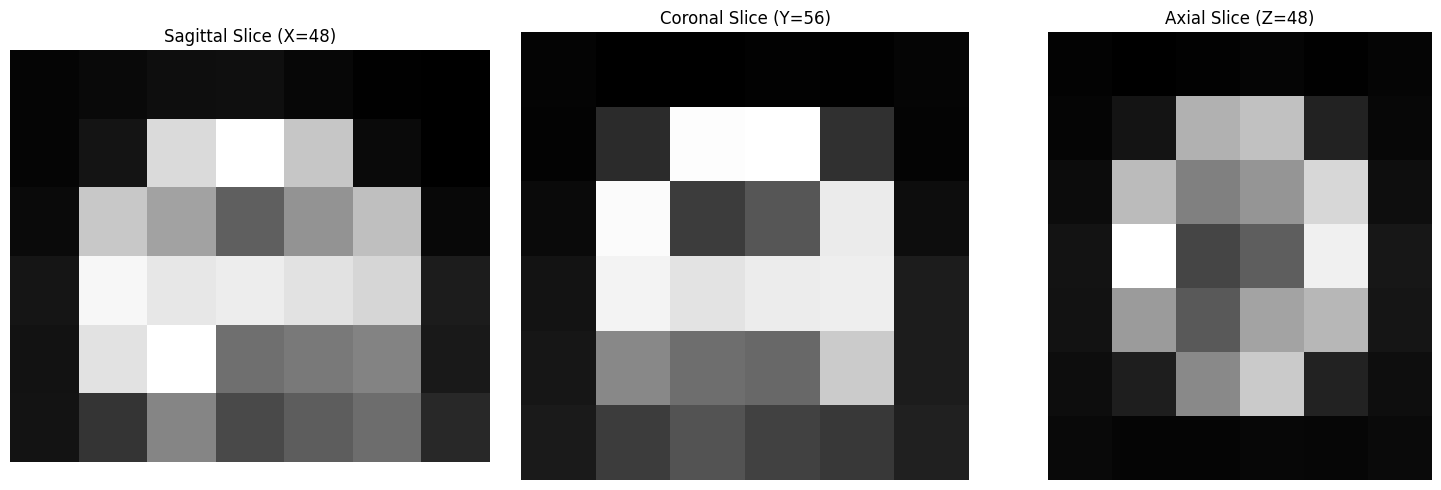

In [16]:
path = os.path.join(combo_results_dir, "train_att_volume.pt")
this = torch.load(path)
view_image_data(this)

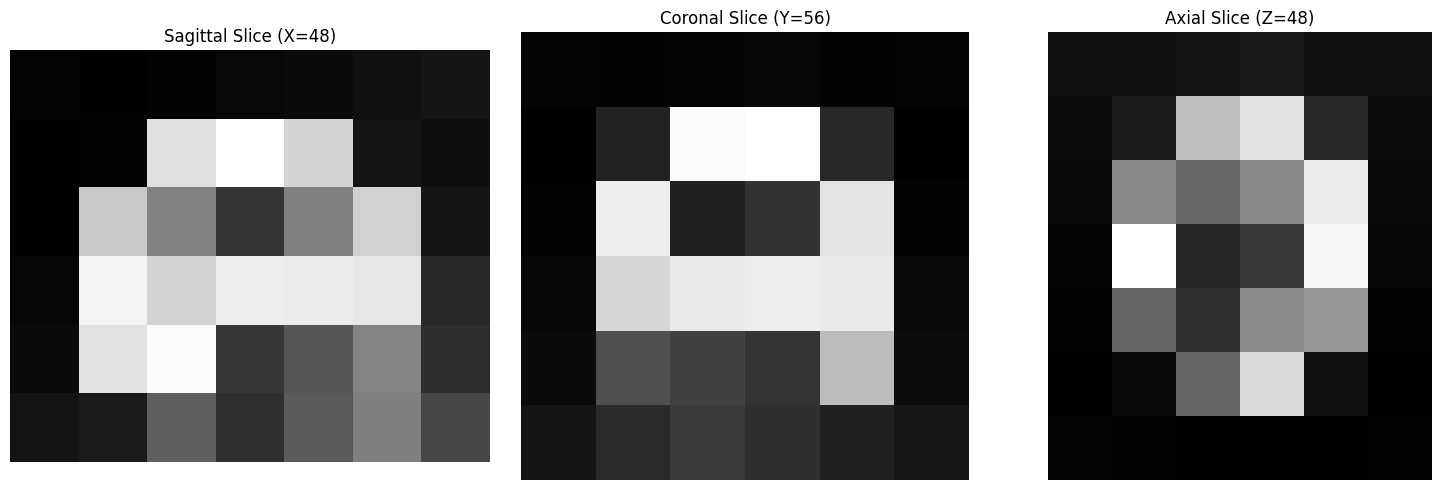

In [17]:
path = "/home/diogommiranda/tese/outputs/roi_guidance/purevit/smci_pmci_balanced/Raw Energy Loss (USE_AVG=True)/Layer12/alpha=1.0/lambda_0.0 (Fold 4) - 604 vf/train_att_volume.pt"
this = torch.load(path)
view_image_data(this)